# Détectez des faux billets - ONCFM

## Partie 1 - Inspection des données

Je commence par importer les librairies pandas, numpy, seaborn et matplotlib.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Premier tour

In [2]:
billets = pd.read_csv("billets.csv", sep=";")
billets.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
billets.tail(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [4]:
billets.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
84,True,171.85,103.91,103.91,4.50,3.21,113.09
972,True,171.40,103.88,103.54,3.75,2.80,113.01
1449,False,171.66,104.10,104.15,4.53,3.40,111.83
1224,False,171.74,104.52,104.23,5.59,3.61,112.14
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


Regardons la structure générale de notre fichier.

In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

Regardons si nous avons des valeurs nulles et/ou dupliquées.

In [7]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [8]:
billets.duplicated().sum()

0

### Régression linéaire multiple

Nous avons remarqué que certaines valeurs de la colonne margin_low sont manquantes. Je vais donc procéder à une regression linéaire multiple pour compléter ces valeurs manquantes.  
Je vais d'abord regarder si ces différents points sont vérifiés :  
 - nous avons une relation linéaire entre nos variables explicatives et la variable à expliquer
 - les variables explicatives sont indépendantes entre elles

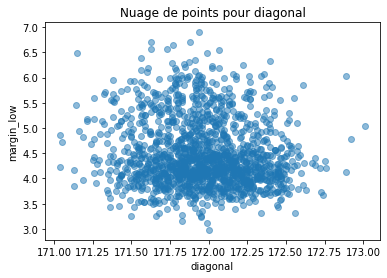

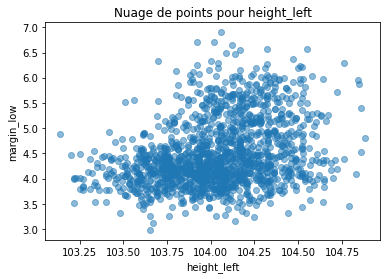

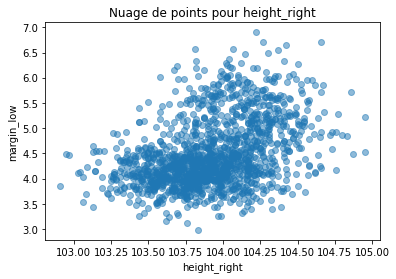

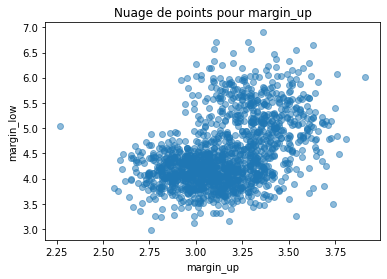

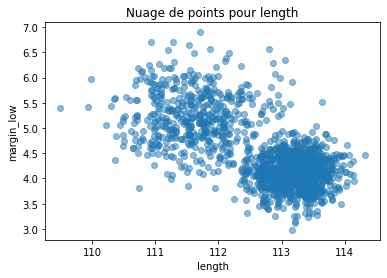

In [9]:
# Extraire les colonnes d'intérêt
variables = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
y_var = 'margin_low'

# Créer les nuages de points
for col in variables:
    plt.scatter(billets[col], billets[y_var], alpha=0.5)
    plt.title('Nuage de points pour ' + col)
    plt.xlabel(col)
    plt.ylabel(y_var)
    plt.show()

Il ne semble pas y avoir de relation linéaire entre la variable à expliquer et les différentes variables explicatives. Cependant je continue l'analyse.

<AxesSubplot:>

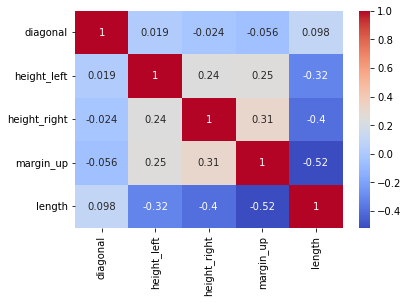

In [10]:
sns.heatmap(billets[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']].corr(), annot=True, cmap='coolwarm')

Je considère que la deuxième condition est vérifiée, les variables explicatives sont indépendantes entre elles. Je lance maintenant la régression multiple, comme demandée, même si les conditions nécéssaires ne sont pas remplies.

J'importe les librairies nécessaires pour la régression linéaire multiple.

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

J'utilise la commande lm pour régresser margin_low en fonction des autres variables de l'échantillon.

In [12]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 10 May 2023   Prob (F-statistic):          2.60e-202
Time:                        20:28:57   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Le $R^{2}$ vaut environ 0.48, tout comme le $R^{2}$ ajusté.  Cette faible valeur du $R^{2}$ signifie que le modèle ne parvient pas à expliquer une grande partie de la variance des données. Autrement dit, les variables explicatives n'ont pas une forte influence sur la variable cible.

On remarque que tous les paramètres sont significatifs. En effet, la p-valeur de tous les paramètres est inférieur à 5 %. Nous les gardons donc tous pour le calcul des valeurs manquantes.

*J'utilise donc ce modèle pour compléter les valeurs manquantes. Tout en sachant qu'il n'est probablement pas le plus pertinent*

In [13]:
billets['margin_low'] = billets['margin_low'].fillna(reg_multi.predict(billets))

In [14]:
billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

### Analyser les résultats de la régression linéaire

Je vais vérifier la colinéarité des variables, tester l’homoscédasticité (c'est-à-dire l'égalité des variances) des résidus et tester la normalité des résidus.

In [15]:
# mesure de la collinéarité des variables
variables_reg = reg_multi.model.exog
[variance_inflation_factor(variables_reg, i) for i in np.arange(1,variables_reg.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [16]:
# test pour l'homoscédasticité
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables_reg)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216217995e-16


La p-valeur ici est inférieure à 5 %, on rejette l'hypothèse nulle 𝐻0. Donc il y a suffisamment de preuves pour affirmer que l'hétéroscédasticité est présente dans les données. Autrement dit on peut conclure qu'il n'y a pas d'égalité des variances entre les échantillons testés.

In [17]:
# pour tester la normalité des résidus, on peut faire un test de Shapiro-Wilk
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

Ici, l'hypothèse de normalité est remise en cause (p-value = 8.53e-11 < 0.05).

### Inspection des données

In [18]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Apres cette analyse rapide, a l'aide de la methode describe, on ne remarque pas de valeurs aberrantes.

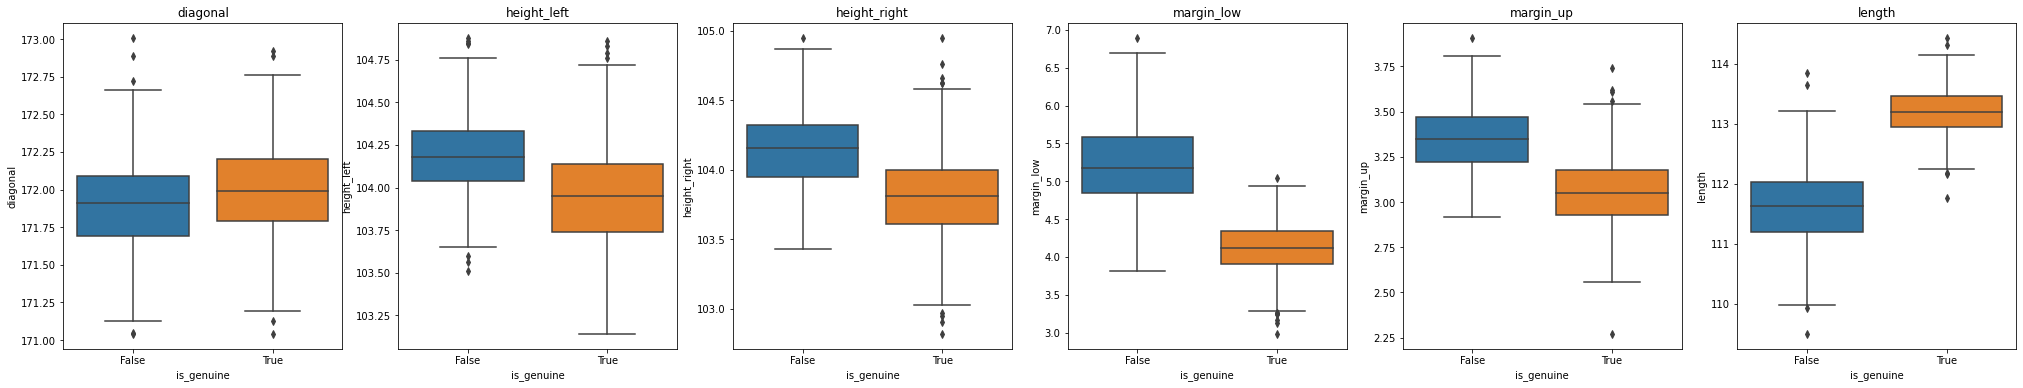

In [19]:
# Créer un subplot pour chaque variable
fig, axs = plt.subplots(ncols=6, figsize=(35,6))

# Boucler sur chaque variable pour tracer les boxplots
for i, col in enumerate(billets.columns[1:]):
    sns.boxplot(x='is_genuine', y=col, data=billets, ax=axs[i])
    axs[i].set_title(col)

# Afficher le graphique
plt.show()

En moyenne on observe que les faux billets sont plus haut à gauche et à droite, ont une marge basse et haute plus élevée. En revanche leur diagonale et leur longueur est plus faible que les vrais billets.

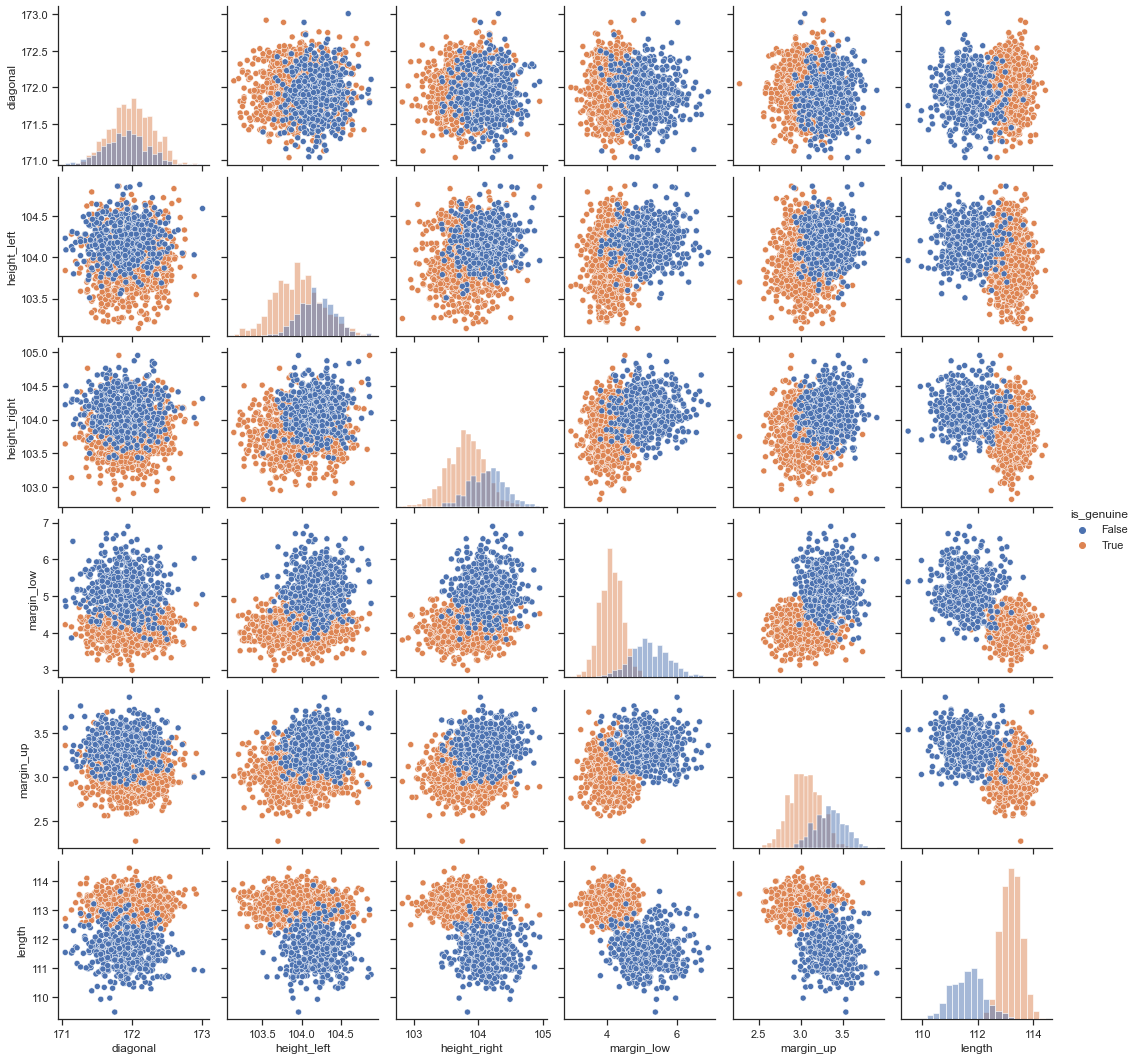

In [20]:
sns.set(style="ticks")

# Créer le pairplot en utilisant la variable booléenne 'is_genuine' pour la couleur
sns.pairplot(billets, hue='is_genuine', diag_kind='hist')

# Afficher le graphique
plt.show()

A l'aide du pairplot, on remarque que les liens négatifs les plus forts sont entre margin_up, margin_low et lenght. Comme cela est confirmé par le heatmap ci dessous.

<AxesSubplot:>

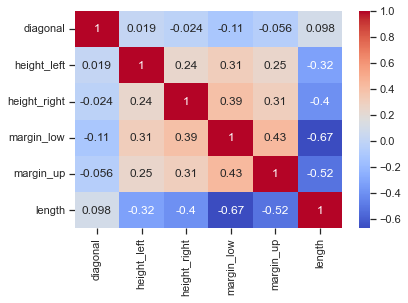

In [21]:
sns.heatmap(billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].corr(), annot=True, cmap='coolwarm')

## Partie 2 - Analyse en composante principale

Comme nous allons utiliser la méthodes des kmeans comme modèle prédictif je vais réaliser une ACP (ou réduction des variables) pour afficher la classification sur le premier plan factoriel.

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
#j'enlève la première colonne
n_billets = billets.drop(billets.columns[0], axis=1)

matrice = n_billets.values
matrice[:5]

array([[171.81, 104.86, 104.95,   4.52,   2.89, 112.83],
       [171.46, 103.36, 103.66,   3.77,   2.99, 113.09],
       [172.69, 104.48, 103.5 ,   4.4 ,   2.94, 113.16],
       [171.36, 103.91, 103.94,   3.62,   3.01, 113.51],
       [171.73, 104.28, 103.46,   4.04,   3.48, 112.54]])

In [24]:
features = n_billets.columns
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(matrice)

In [26]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,-0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [27]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

In [28]:
pca.explained_variance_ratio_

array([0.43288253, 0.16956616, 0.13025062, 0.11824871, 0.09602704,
       0.05302493])

In [29]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
scree_cum
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

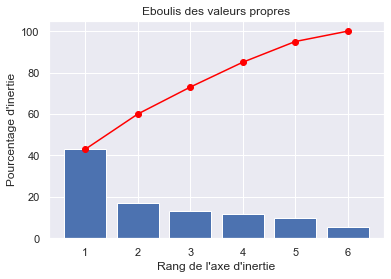

In [30]:
sns.set()
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Avec l'eboulis des valeurs propres on voit que deux composantes expliquent 65% de la variabilite de nos donnees.

In [31]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5
0,-0.084698,0.330634,0.393555,0.507693,0.439415,-0.527052
1,0.941304,0.307528,0.108332,-0.072440,-0.004954,0.048636
2,-0.287843,0.885049,-0.163563,-0.109046,-0.270112,0.149099
3,-0.101961,-0.049244,0.866562,-0.089271,-0.444047,0.176360
4,-0.115992,0.101652,0.235998,-0.564088,0.711988,0.308863
5,0.008341,0.006130,0.001091,0.631621,0.172701,0.755725


In [32]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.39,0.51,0.44,-0.53
F2,0.94,0.31,0.11,-0.07,-0.00,0.05
F3,-0.29,0.89,-0.16,-0.11,-0.27,0.15
F4,-0.10,-0.05,0.87,-0.09,-0.44,0.18
F5,-0.12,0.10,0.24,-0.56,0.71,0.31
F6,0.01,0.01,0.00,0.63,0.17,0.76


<AxesSubplot:>

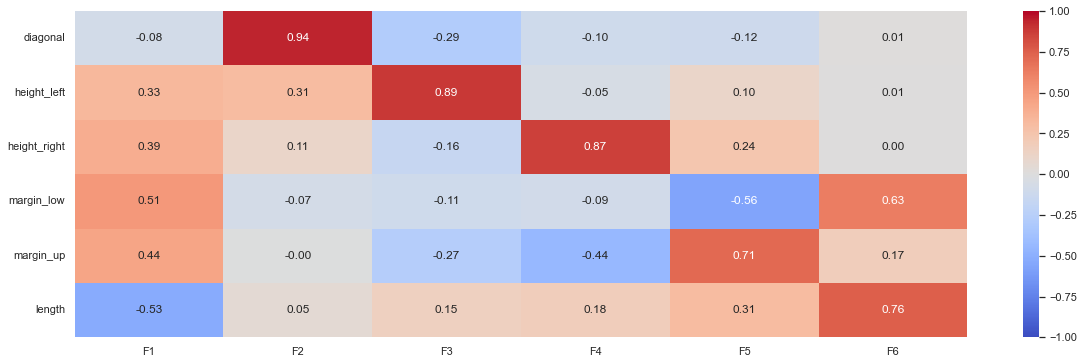

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Ci dessus on peut voir sur la heatmap que diagonal est fortement correle avec la composante F2. Alors que margin_low et margin_up sont positivement correle avec la composante F1, lenght etant correle negativement avec F1.

In [34]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Cela est confirme avec le cercle des correlations sur F1 et F2 ci dessous.

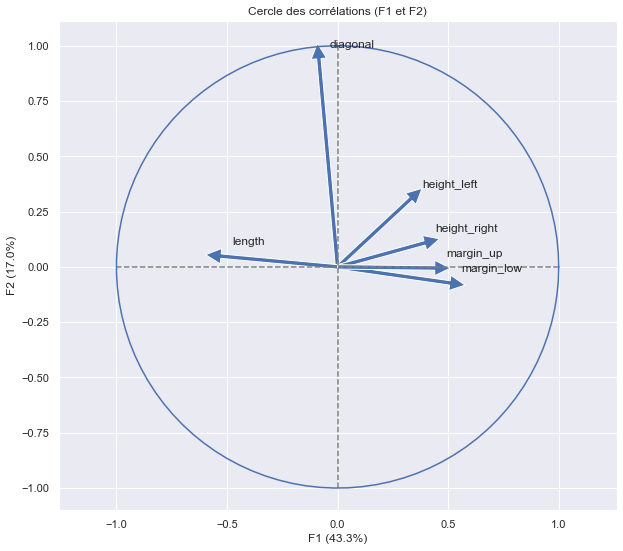

In [35]:
correlation_graph(pca, (0,1), features)

In [36]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[ 1.64413533,  0.74784336,  2.40251671,  3.18085156,  0.30398483,
        -0.01224666],
       [-2.01990995, -2.20749245, -1.00186403,  0.07293664,  0.03333482,
        -0.47550345],
       [-0.969864  ,  2.62049228,  1.19536388, -0.92362716, -0.83774922,
         0.2073435 ],
       [-1.37746195, -1.8183704 ,  0.6511098 ,  0.82815499,  0.79956344,
        -0.23099664],
       [ 0.14871192, -0.56672188,  0.85404268, -1.78771257,  1.17788283,
        -0.30258119]])

In [37]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette="Set1")

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

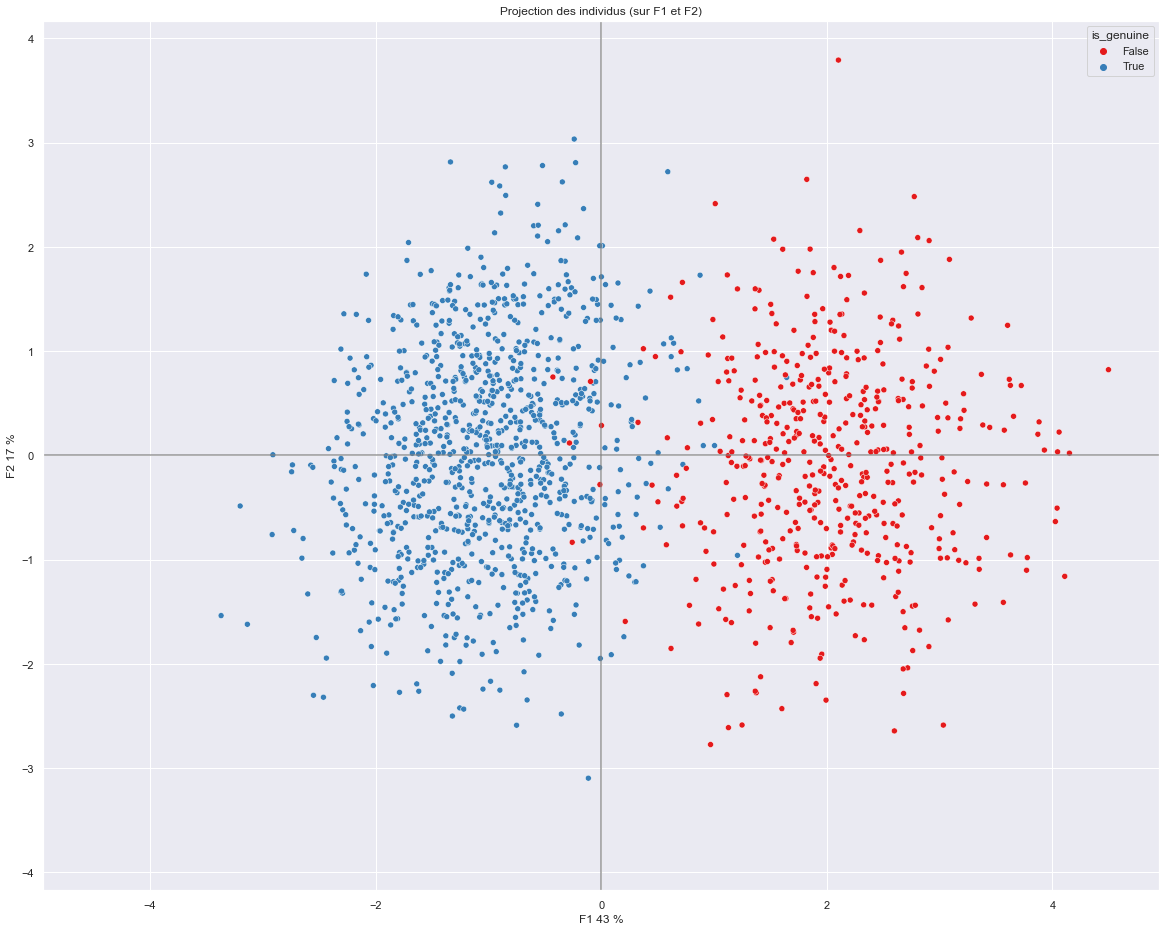

In [38]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=None, clusters=billets["is_genuine"], figsize=(20,16), marker="o")

La projection des individus (billets) sur le premier plan factoriel F1 et F2 nous montre deux groupes assez distincts qui correspondent au billets True ou False.

## Partie 3 - Modélisation

### Inspection des données de la target (is_geniune)

In [39]:
billets.iloc[:,0].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [40]:
billets.iloc[:,0].value_counts(normalize=True).round(2)

True     0.67
False    0.33
Name: is_genuine, dtype: float64

<AxesSubplot:ylabel='is_genuine'>

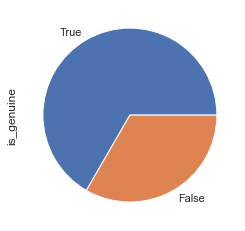

In [41]:
billets.iloc[:,0].value_counts().plot(kind="pie")

### Préparation des données

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
# estimateurs
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

In [43]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [44]:
X = billets.drop(columns='is_genuine')
y = billets.is_genuine

In [45]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [46]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool

Apres la preparation des donnees je commence par entrainer un modele de classificateur aleatoire. Pour pouvoir comparer ses resultats avec un modele de regression logistique par la suite et avec un modele predictif kmeans pour terminer. Ensuite nous pourrons determiner lequel de ces modeles est le plus performant.

### Test train split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [48]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape} ")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape} ")

Nous avons X_train de forme (1050, 6) et y_train de forme (1050,) 
Nous avons X_test de forme (450, 6) et y_test de forme (450,) 


## - Dummy Classifier

J'utilise le DummyClassifier pour donner une idée du score de base que l'algorithme le plus simple obtiendrait en faisant des prédictions. 

In [49]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [50]:
y_pred = estimator.predict(X_test)
y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [51]:
pd.Series(y_pred).value_counts()

True    450
dtype: int64

In [52]:
y_test.value_counts(normalize=True)

True     0.642222
False    0.357778
Name: is_genuine, dtype: float64

Je cree une fonction score pour calculer le score de l'estimateur (DummyClassifier ou Régression logistique dans notre exemple)

In [53]:
def score(estimator):
    """Calcul et présente le train score et le test score"""
    
    tr_score = estimator.score(X_train, y_train).round(3)
    te_score = estimator.score(X_test, y_test).round(3)
    
    print(f"Score train : {tr_score} \nScore test : {te_score}")

In [54]:
score(estimator)

Score train : 0.677 
Score test : 0.642


Je cree une fonction pour afficher la matrice de confusion.

In [55]:
def confusion(y_test, y_pred):
    """Pour une matrice de confusion plus jolie"""
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]

    # Remplacer pred_0 par pred_False et pred_1 par pred_True (idem pour test)
    mat.columns = ['pred_False' if col == 'pred_0' else 'pred_True' for col in mat.columns]
    mat.index = ['test_False' if idx == 'test_0' else 'test_True' for idx in mat.index]

    return mat

In [56]:
confusion(y_test, y_pred)

,pred_False,pred_True
test_False,0,161
test_True,0,289


Ici on voit que le premier modele aleatoire a pris la donnee la plus repandue (True) et a retourne a chaque fois ce resultat. On obtient un score de 0.64.

## - Régression Logistique

In [57]:
estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [58]:
y_pred = estimator.predict(X_test)
y_pred

array([False, False,  True,  True,  True,  True, False,  True, False,
        True,  True, False,  True, False,  True, False, False,  True,
        True,  True, False, False,  True, False, False,  True,  True,
       False, False, False, False,  True, False, False,  True,  True,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True, False,
       False,  True,

In [59]:
y_prob = estimator.predict_proba(X_test).round(3)
y_prob

array([[0.998, 0.002],
       [0.993, 0.007],
       [0.005, 0.995],
       [0.007, 0.993],
       [0.002, 0.998],
       [0.002, 0.998],
       [0.979, 0.021],
       [0.001, 0.999],
       [0.987, 0.013],
       [0.003, 0.997],
       [0.01 , 0.99 ],
       [0.999, 0.001],
       [0.002, 0.998],
       [1.   , 0.   ],
       [0.01 , 0.99 ],
       [0.997, 0.003],
       [0.978, 0.022],
       [0.012, 0.988],
       [0.003, 0.997],
       [0.003, 0.997],
       [1.   , 0.   ],
       [0.958, 0.042],
       [0.153, 0.847],
       [0.977, 0.023],
       [0.998, 0.002],
       [0.006, 0.994],
       [0.489, 0.511],
       [0.999, 0.001],
       [0.994, 0.006],
       [0.591, 0.409],
       [0.993, 0.007],
       [0.052, 0.948],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.007, 0.993],
       [0.01 , 0.99 ],
       [0.033, 0.967],
       [0.033, 0.967],
       [0.977, 0.023],
       [0.008, 0.992],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.983, 0.017],
       [0.0

In [60]:
score(estimator)
confusion(y_test, y_pred)

Score train : 0.99 
Score test : 0.987


,pred_False,pred_True
test_False,156,5
test_True,1,288


Avec le modele de regression logistique on obtient de bien meilleur resultat, puisque le score et de 0.99. Presque parfait !
  
Et grace a la matrice de confusion on peut voir que le modele n'a fait qu'une seule erreur pour les True et 5 erreurs pour les False. Le faux positif est 5 (il a predit comme vrai alors que c'etait faux) et le faux negatif est de 1 (il a predit comme faux alors que c'etait vrai).

#### Courbe ROC

In [61]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.98


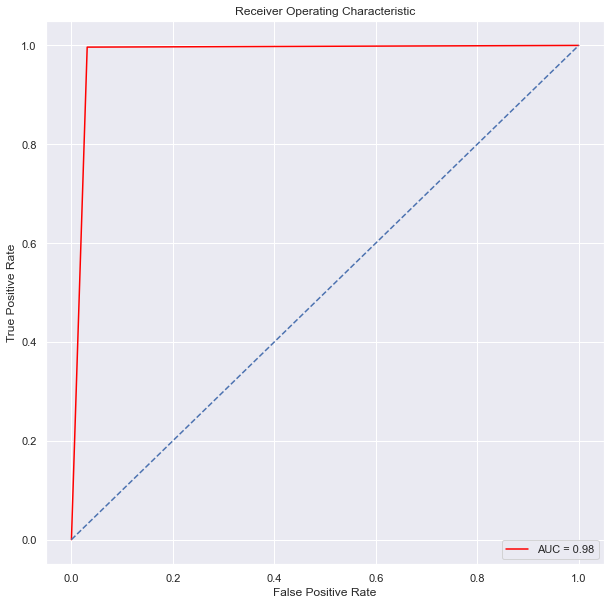

In [62]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plus la valeur de l'aire sous la courbe est proche de 1, meilleure est la capacité du modèle à distinguer les classes. 
  
Dans ce cas, l'aire sous la courbe est de 0,98, ce qui indique que le modèle a de bonnes performances de prédiction en termes de sensibilité et de spécificité pour distinguer les vrais positifs des faux positifs.

## - Méthode des kmeans

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

Nous allons utiliser la méthode du coude et le coefficient de silhouette pour déterminer le nombre de cluster optimal.

In [66]:
#j'enlève la derniere colonne
n_billets = X_test_with_predictions.drop(X_test_with_predictions.columns[6], axis=1)

#J'applique les differentes etapes pour centrer reduire les donnees
matrice = n_billets.values
X_scaled = scaler.fit_transform(matrice)
X_proj = pca.transform(X_scaled)


In [75]:
inertia = []
k_list = range(1, 10)

for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled) 
  inertia.append(kmeans.inertia_)

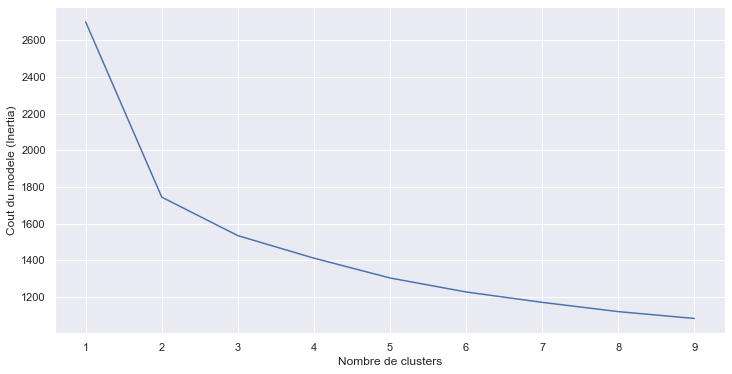

In [76]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("Cout du modele (Inertia)")
ax.set_xlabel("Nombre de clusters")
ax = plt.plot(k_list, inertia)

COEFFICIENT DE SILHOUETTE

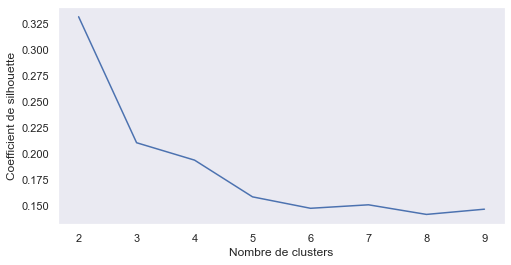

[0.3312187567973115,
 0.21058994539816042,
 0.19392138396183375,
 0.15876142568076326,
 0.14781473403900555,
 0.15115494551595912,
 0.1419477477461796,
 0.1469571736239135]

In [77]:
from sklearn.metrics import silhouette_score
tab_silhouette =[]
k_range=range(2,10)
for k in k_range:
    model=KMeans(n_clusters=k)
    cluster_labels=model.fit_predict(X_scaled)
    tab_silhouette.append(silhouette_score(X_scaled,cluster_labels))

fig = plt.figure(figsize=(8,4))
plt.plot(k_range,tab_silhouette)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.grid()
plt.show()
tab_silhouette

Le coefficient de silhouette nous donne 2 clusters avec le score le plus élevé. De plus avec la méthode du coude nous voyons que la courbe se plit significativement a deux clusters. Nous allons donc partir sur 2 clusters pour notre modele.

In [64]:
X = billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = billets['is_genuine']

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle KMeans sur les données d'entraînement
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Prédire les étiquettes pour les données de test
predictions = kmeans.predict(X_test)

Je souhaite ajouter maintenant les predictions a mon dataset. Dans le but de pouvoir projeter les predictions sur les deux plans factoriels par la suite.

In [65]:
# Ajouter les prédictions à X_test
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Cluster_kmeans'] = predictions

# Afficher les premières lignes du DataFrame avec la colonne des prédictions
X_test_with_predictions.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster_kmeans
1116,172.26,103.90,104.12,4.990000,3.42,111.27,1
1368,171.65,104.32,104.38,5.650000,3.24,112.30,1
422,171.53,103.53,103.63,4.040000,2.96,112.76,0
413,172.30,103.66,103.50,4.160539,3.16,112.95,0
451,172.17,103.79,103.54,4.070000,2.78,113.03,0


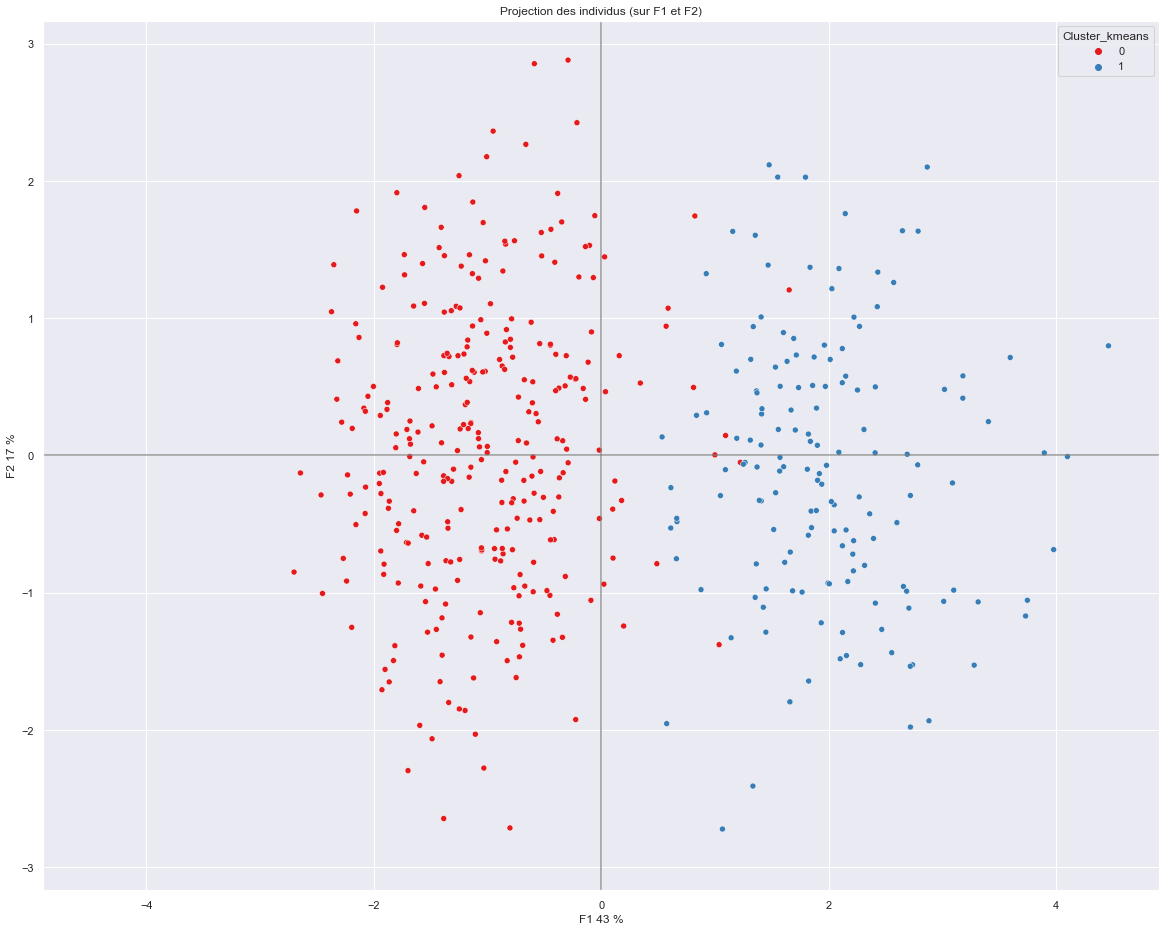

In [67]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=None, clusters=X_test_with_predictions['Cluster_kmeans'], figsize=(20,16), marker="o")

Avec cette projection on peut voir les deux groupes apparaitres comme vu plus haut. On voit aussi que les 0 correspondent au True et les 1 au False.

In [68]:
# Remplacer les 0 et 1 par True et False
bool_predictions = np.array([False if pred == 1 else True for pred in predictions])

confusion(y_test, bool_predictions)

,pred_False,pred_True
test_False,154,7
test_True,0,289


Avec le modele des kmeans on obtient des resultats legerement moins bons, meme si superieurs au classificateur aleatoire.
  
Grace a la matrice de confusion on peut voir que le modele a fait 7 erreurs pour les False. Le faux positif est 7 (il a predit comme vrai alors que c'etait faux) et le faux negatif est de 0 (il a predit comme faux alors que c'etait vrai).  

Ces resultats sont donc moins bons que ceux obtenus avec la regression logistique.

Pour cette raison je vais donc choisir le modele de regression logistique. Il est comme on l'a vu le plus performant. Il me servira donc dans la creation de l'algorithme de prediction ci dessous.

## Partie 4 - Fonction pour tester nouveau fichier

In [69]:
import tkinter as tk
from tkinter import filedialog

def regression_logistique_():
    # Initialise une fenêtre Tkinter cachée, probleme de compatibilite avec MacOs
    racine = tk.Tk()
    racine.withdraw()
    
    # Demande à l'utilisateur de saisir le chemin d'accès du fichier CSV
    chemin_acces = filedialog.askopenfilename(filetypes=[("Fichiers CSV", "*.csv")])
    
    # Charge le fichier CSV en utilisant Pandas
    df = pd.read_csv(chemin_acces)
    
    # Sépare les données en entrées (X) et en sortie (y)
    X_analyse = df.drop(columns=['id'])
    
    # Ajoute une colonne pour les résultats de la régression au fichier CSV
    df['Résultats'] = estimator.predict(X_analyse)
    
    # Ajoute une colonne pour les scores de probabilité de la prédiction
    probabilites = estimator.predict_proba(X_analyse).round(2)
    df['Probabilité (%)'] = [max(prob) * 100 for prob in probabilites]
    
    # Enregistre le fichier CSV avec la colonne de résultats
    df.to_csv(chemin_acces, index=False)
    
    print("La régression logistique a été réalisée avec succès. Le fichier CSV a été mis à jour avec les résultats.")
    
    # Retourne le DataFrame pour l'afficher
    return df

In [73]:
regression_logistique_()

La régression logistique a été réalisée avec succès. Le fichier CSV a été mis à jour avec les résultats.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,Résultats,Probabilité (%)
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True,99.0
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False,99.0
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True,100.0
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False,100.0
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False,98.0
